 <h1><b>Trafik Kazalarından Yaralanma Şiddetinin Tahmini</b></h1>
 
 <h3><b>Projenin Amacı:</b><h3/>
 
Chicago’da meydana gelen trafik kazalarıyla ilgili bilgileri inceleyerek bir kazada insanları ne kadar yaralanabileceğini önceden tahmin edebilmektir. Eğer kaza bilgisi bize kazanın büyüklüğü, konumu, araç tipi gibi bilgiler veriyorsa, bu bilgiler kullanılarak bir model oluşturulabilir. Bu model sayesinde kaza gerçekleştikten hemen sonra, kaza hakkında çok kısa sürede bilgi toplanabilir ve bu bilgiler doğrultusunda tahmin yapılabilir.
Bu sayede kazaların hafif mi olduğunu, orta derecede mi, tehlikeli durumlar mı olduğu anlaşılabilir ve buna göre aksiyonlar alınabilir. Böylece trafik kazalarında acil müdahale ekiplerinin daha etkin şekilde yönlendirilmesi sağlanabilir.
Ayrıca, bu model sayesinde kaza verileri kullanılarak bir tahmin sistemi oluşturulabilir, bu sistem belirli bölgelerde daha sık kazaların meydana geldiğini göstermesiyle yol koşullarının daha dikkatli bir şekilde analiz edilmesini ve önlemler alınmasını sağlayabilir.

 <h5>Gerekli Kütüphanelerin Tanımlanması</h5>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
RNG = 42
np.random.seed(RNG)

<h5>Bu kodda, veri yükleme işlemi başlatılır. İlk satırda kullanıcıya bilgi vermek için bir mesaj yazdırılır. Ardından Traffic_Crashes.csv dosyası pandas ile okunarak df adlı veri çerçevesine aktarılır.
</h5>

In [3]:
print("--- Veri Yükleniyor ---")
df = pd.read_csv("../yaralanma_siddeti_tahmini/Traffic_Crashes.csv")

--- Veri Yükleniyor ---


<h5>Bu kod, veri seti hakkında temel bilgileri ekrana yazdırır.</h5>

In [4]:
print("Orijinal veri boyutu:", df.shape)
print("Sütun sayısı:", len(df.columns))

Orijinal veri boyutu: (300000, 48)
Sütun sayısı: 48


<h5>Veri setinden ilk 5 satırı verir.</h5>

In [5]:
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,98df5755b18bc25a67163bb832c0fd2b72c41631ef6e7d...,NaN,02/03/2025 06:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,UNKNOWN,UNKNOWN,PEDESTRIAN,DIVIDED - W/MEDIAN (NOT RAISED),...,1.0,0.0,1.0,0.0,6,2,2,41.904354,-87.721531,POINT (-87.721531234586 41.904353607338)
1,4e85802a19266b7c4c848561724da842d34a2509a4d931...,NaN,06/16/2022 01:50:00 AM,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,...,1.0,0.0,0.0,0.0,1,5,6,41.800640,-87.620846,POINT (-87.620846187015 41.800640445503)
2,d747392bff241c36c7ecbc171143947f6b93896a72a4ce...,NaN,01/19/2024 06:11:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,FREEZING RAIN/DRIZZLE,DAYLIGHT,REAR END,CENTER TURN LANE,...,1.0,0.0,1.0,0.0,18,6,1,41.659126,-87.559433,POINT (-87.559432741943 41.659126189932)
3,54aa7076c5ff7e2667d07268186d95064cad67ffa84e89...,NaN,02/01/2025 01:00:00 PM,30,NO CONTROLS,NO CONTROLS,UNKNOWN,DAYLIGHT,REAR TO SIDE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,13,7,2,41.705506,-87.535139,POINT (-87.535139453239 41.7055064825)
4,ac3f58b20d6ca95846e085b053618467d967c51f68d2c1...,NaN,07/14/2025 08:45:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,8,2,7,41.850620,-87.632113,POINT (-87.632112683668 41.850620317342)


<h5>Veri yapısı hakkında bilgi verir.</h5>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                300000 non-null  object 
 1   CRASH_DATE_EST_I               19194 non-null   object 
 2   CRASH_DATE                     300000 non-null  object 
 3   POSTED_SPEED_LIMIT             300000 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         300000 non-null  object 
 5   DEVICE_CONDITION               300000 non-null  object 
 6   WEATHER_CONDITION              300000 non-null  object 
 7   LIGHTING_CONDITION             300000 non-null  object 
 8   FIRST_CRASH_TYPE               300000 non-null  object 
 9   TRAFFICWAY_TYPE                300000 non-null  object 
 10  LANE_CNT                       56674 non-null   float64
 11  ALIGNMENT                      300000 non-null  object 
 12  ROADWAY_SURFACE_COND          

<h5>Bu kod, DataFrame’deki sütunların veri tiplerini sayarak özet bir tablo halinde ekrana yazdırır.</h5>

In [7]:
print("\n--- Veri tipi özet ---")
print(df.dtypes.value_counts())


--- Veri tipi özet ---
object     31
float64    11
int64       6
Name: count, dtype: int64


<h5>DataFrame’deki hız sınırı değerlerini kontrol eder, 0 ile 90 arası olmayanları temizler.</h5>

In [8]:
print("\n--- Mantıksal Kontroller Yapılıyor ---")

# Hız sınırı kontrolü (0 ile 90 arası makul kabul edildi)
hatali_hiz_sayisi = df[(df['POSTED_SPEED_LIMIT'] < 0) | (df['POSTED_SPEED_LIMIT'] > 90)].shape[0]
if hatali_hiz_sayisi > 0:
    print(f"{hatali_hiz_sayisi} adet mantıksız hız sınırı değeri tespit edildi ve temizleniyor.")
    df = df[(df['POSTED_SPEED_LIMIT'] >= 0) & (df['POSTED_SPEED_LIMIT'] <= 90)]
else:
    print("Hız sınırları mantıksal aralıkta.")



--- Mantıksal Kontroller Yapılıyor ---
19 adet mantıksız hız sınırı değeri tespit edildi ve temizleniyor.


<h5>DataFrame’deki sütunlarda eksik değerleri sayar, yüzdesini hesaplar ve en çok eksik olanları listeler.</h5>

In [9]:
# Eksik değer analiz tablosu
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

eksik_df.head(50)

,eksik_sayisi,eksik_yuzdesi
WORKERS_PRESENT_I,299554,99.857658
WORK_ZONE_TYPE,298689,99.569306
WORK_ZONE_I,298223,99.413963
DOORING_I,297618,99.212283
PHOTOS_TAKEN_I,295278,98.432234
STATEMENTS_TAKEN_I,289818,96.612119
NOT_RIGHT_OF_WAY_I,288431,96.149756
CRASH_DATE_EST_I,280787,93.601595
LANE_CNT,243312,81.109137
HIT_AND_RUN_I,215016,71.676540


<h5>DataFrame’deki sütunlarda eksik değerlerin yüzdesini hesaplar ve en çok eksik olan ilk 15 sütunu yatay bar grafiğiyle görselleştirir.</h5>

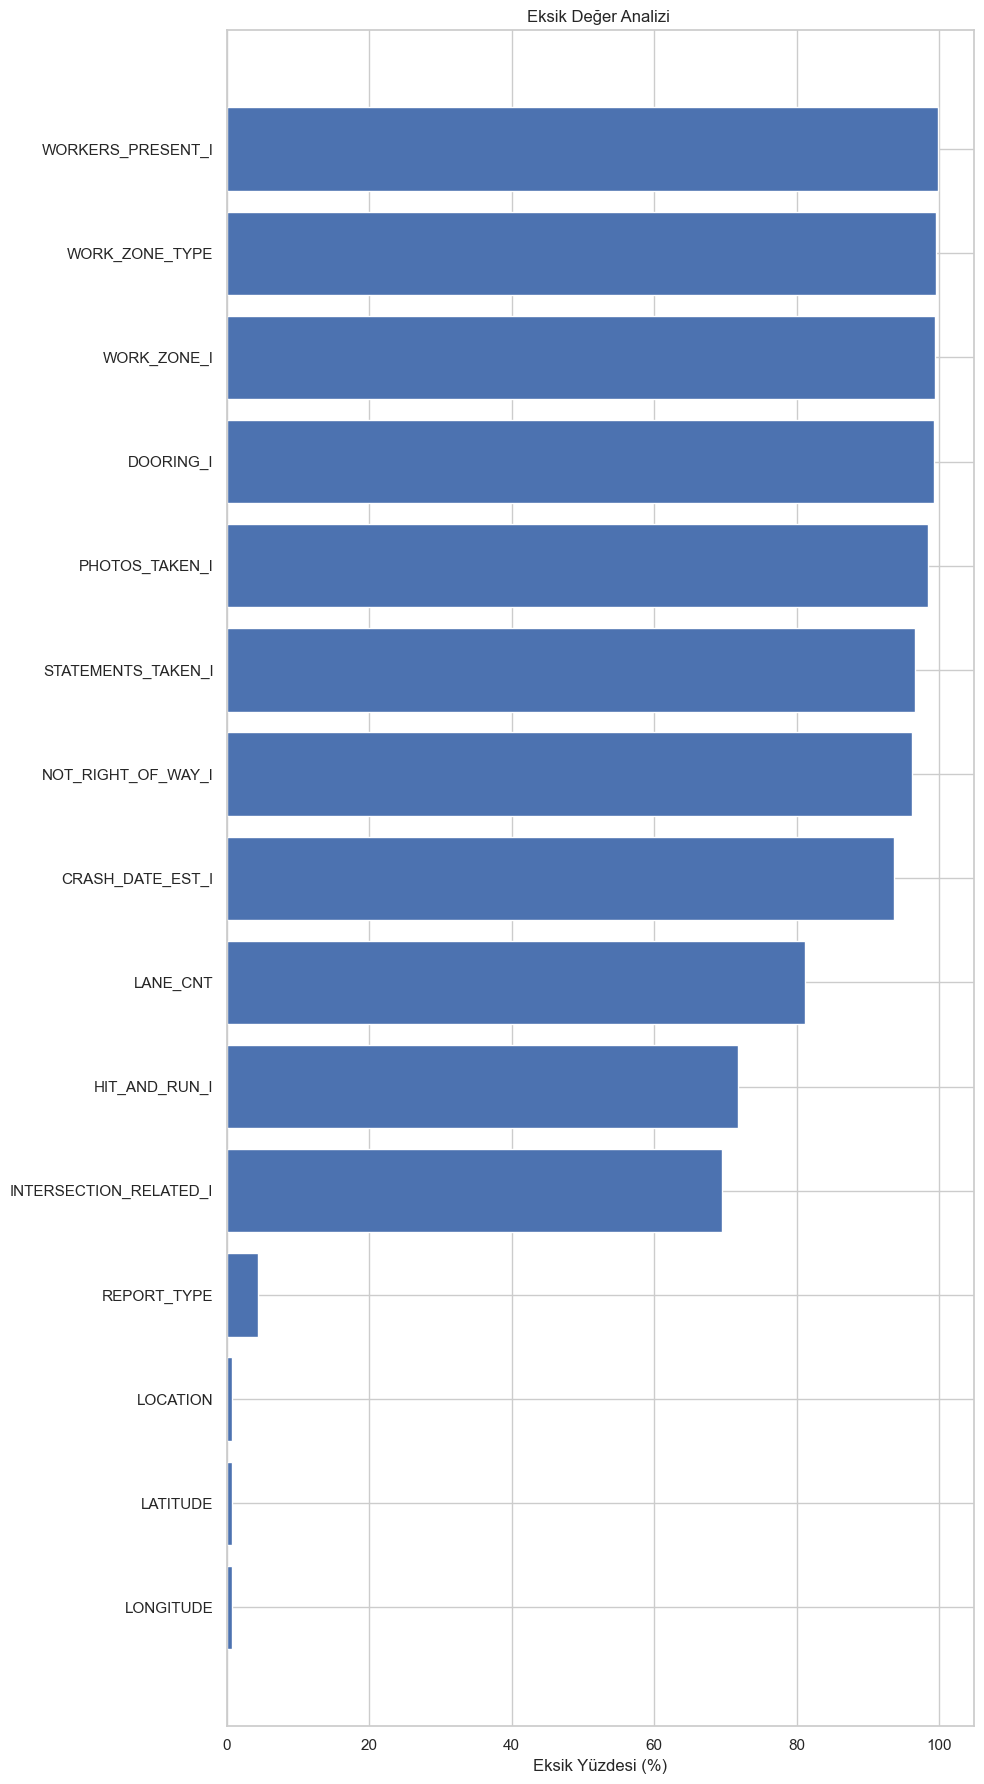

In [10]:
import matplotlib.pyplot as plt

# Eksik değer tablosu 
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)


plt.figure(figsize=(10, 18))
plt.barh(eksik_df.head(15).index, eksik_df.head(15)['eksik_yuzdesi'])
plt.xlabel("Eksik Yüzdesi (%)")
plt.title("Eksik Değer Analizi ")
plt.gca().invert_yaxis()  # En yüksek değeri üstte göstermek için
plt.tight_layout()
plt.show()

<h5>DataFrame’deki sütunların benzersiz değer sayılarını hesaplar ve en çok farklı değere sahip ilk 20 sütunu listeler.</h5>

In [11]:
df.nunique().sort_values(ascending=False).head(20)

CRASH_RECORD_ID                299981
DATE_POLICE_NOTIFIED           276882
CRASH_DATE                     262635
LOCATION                       146837
LATITUDE                       146832
LONGITUDE                      146830
STREET_NO                       10535
STREET_NAME                      1477
BEAT_OF_OCCURRENCE                276
INJURIES_NO_INDICATION             41
PRIM_CONTRIBUTORY_CAUSE            40
SEC_CONTRIBUTORY_CAUSE             40
POSTED_SPEED_LIMIT                 36
LANE_CNT                           27
CRASH_HOUR                         24
TRAFFICWAY_TYPE                    20
INJURIES_NON_INCAPACITATING        20
INJURIES_TOTAL                     20
TRAFFIC_CONTROL_DEVICE             19
FIRST_CRASH_TYPE                   18
dtype: int64

<h5>Belirlenen gereksiz sütunları DataFrame’den siler ve yeni veri boyutunu ekrana yazdırır.</h5>

In [12]:
silinecek_sutunlar = [
    'WORKERS_PRESENT_I','DOORING_I','WORK_ZONE_TYPE','WORK_ZONE_I',
    'PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','NOT_RIGHT_OF_WAY_I',
    'CRASH_DATE_EST_I','LANE_CNT','INTERSECTION_RELATED_I','HIT_AND_RUN_I',
    'LATITUDE','LONGITUDE','CRASH_RECORD_ID','CRASH_DATE','DATE_POLICE_NOTIFIED',
    'STREET_NO','STREET_DIRECTION','STREET_NAME','LOCATION','REPORT_TYPE', 'BEAT_OF_OCCURRENCE'
]

df.drop(columns=silinecek_sutunlar, inplace=True)
print("Veri boyutu:", df.shape)

Veri boyutu: (299981, 26)


<h5>Modelin tahminini doğrudan etkileyecek yaralanma sütunlarını (leakage) veri setinden kaldırır ve yeni boyutu gösterir.</h5>

In [13]:
# Yaralanma sütunlarını kaldırma (leakage engelleme)
leak_cols = [
    'INJURIES_TOTAL','INJURIES_FATAL','INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION','INJURIES_UNKNOWN'
]

df.drop(columns=[c for c in leak_cols if c in df.columns], inplace=True)
print("Veri boyutu:", df.shape)


Veri boyutu: (299981, 19)


<h5>Veri setinde hedef değişkeni (MOST_SEVERE_INJURY) ayırır; X özellikleri, y ise hedefi içerir.</h5>

In [14]:
target = "MOST_SEVERE_INJURY"

X = df.drop(columns=[target])
y = df[target]


<h5>Hedef değişkenin (MOST_SEVERE_INJURY) sınıf dağılımını hem yatay bar grafiği hem de pasta grafiğiyle görselleştirir.</h5>

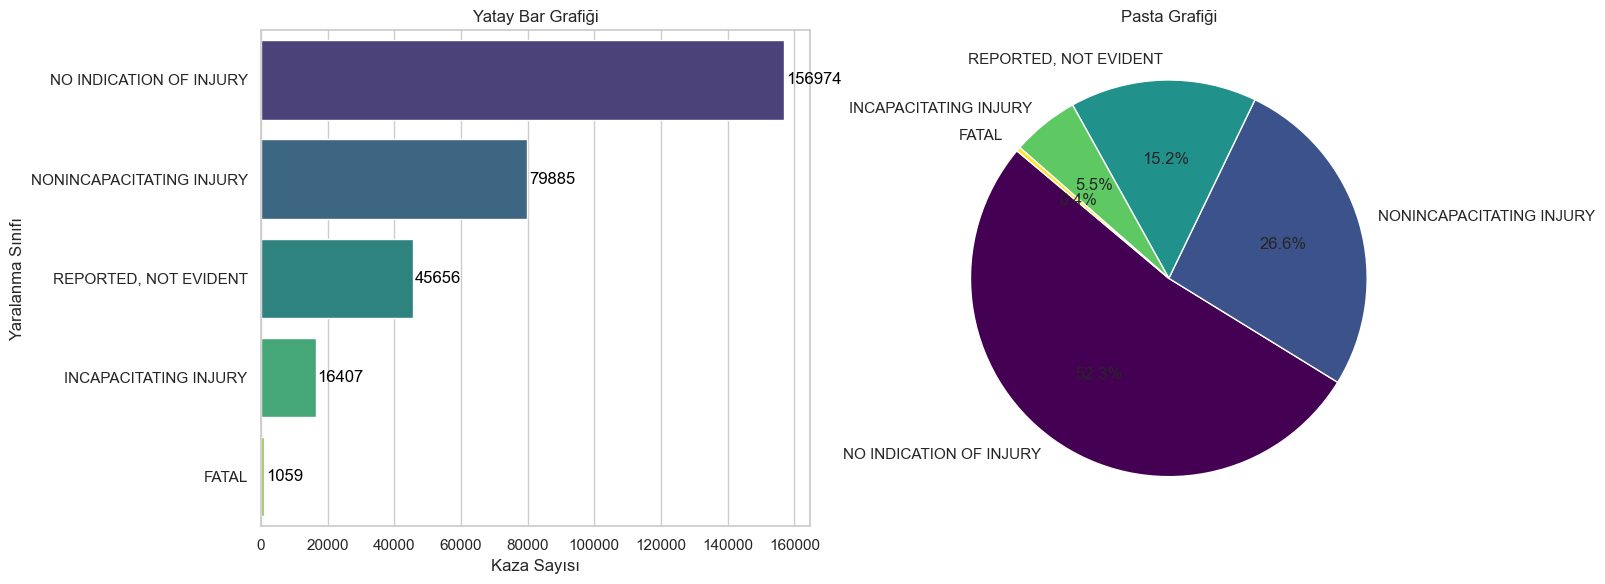

In [15]:
sayi = df[target].value_counts(dropna=False).sort_values(ascending=False)
etiketler = [str(i) if pd.notna(i) else 'NaN' for i in sayi.index]

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
barlar_yatay = sns.barplot(y=etiketler, x=sayi.values, palette="viridis")
for i, v in enumerate(sayi.values):
    barlar_yatay.text(v + 500, i, str(v), color='black', va='center')
plt.title("Yatay Bar Grafiği")
plt.xlabel("Kaza Sayısı")
plt.ylabel("Yaralanma Sınıfı")

plt.subplot(1, 2, 2)
plt.pie(sayi.values, labels=etiketler, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.viridis(np.linspace(0, 1, len(sayi))))
plt.title("Pasta Grafiği")
plt.tight_layout()
plt.show()

<h5>Hedef değişkenin sınıf dağılımını yüzdesel olarak hesaplar ve ciddi dengesizlik varsa uyarı verir.</h5>

In [16]:

print(f"\n--- Hedef Değişken ({target}) Sınıf Dağılımı ---")
sinif_dagilimi = df[target].value_counts(normalize=True) * 100
print(sinif_dagilimi)

if sinif_dagilimi.max() > 80:
    print("\n[UYARI] Ciddi bir sınıf dengesizliği var. Model eğitiminde 'class_weight' veya SMOTE kullanılması önerilir.")
else:
    print("\nSınıf dağılımı kabul edilebilir düzeyde.")


--- Hedef Değişken (MOST_SEVERE_INJURY) Sınıf Dağılımı ---
MOST_SEVERE_INJURY
NO INDICATION OF INJURY     52.327981
NONINCAPACITATING INJURY    26.630020
REPORTED, NOT EVIDENT       15.219631
INCAPACITATING INJURY        5.469346
FATAL                        0.353022
Name: proportion, dtype: float64

Sınıf dağılımı kabul edilebilir düzeyde.


<h5>Veri setini %20 test, %5 validation ve %75 train olarak ayırır ve boyutlarını gösterir.</h5>

In [17]:
# 1) %20 test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 2) %80 içinden %6.25 → %5 validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.0625,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (224985, 18)
Val: (14999, 18)
Test: (59997, 18)


<h5>Hava durumu ile yaralanma şiddeti arasındaki ilişkiyi yığılmış bar grafiğiyle görselleştirir.</h5>

<Figure size 2000x600 with 0 Axes>

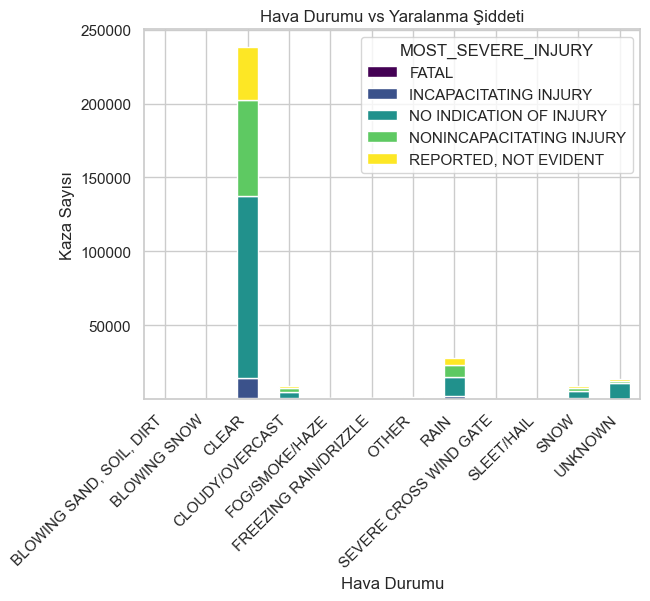

In [18]:
plt.figure(figsize=(20,6))
cross = df.groupby(['WEATHER_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
cross.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Hava Durumu vs Yaralanma Şiddeti")
plt.xlabel("Hava Durumu")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=45, ha='right')
plt.show()

<h5>Train veri setindeki hız sınırı değerlerinin dağılımını histogram grafiğiyle görselleştirir.</h5>

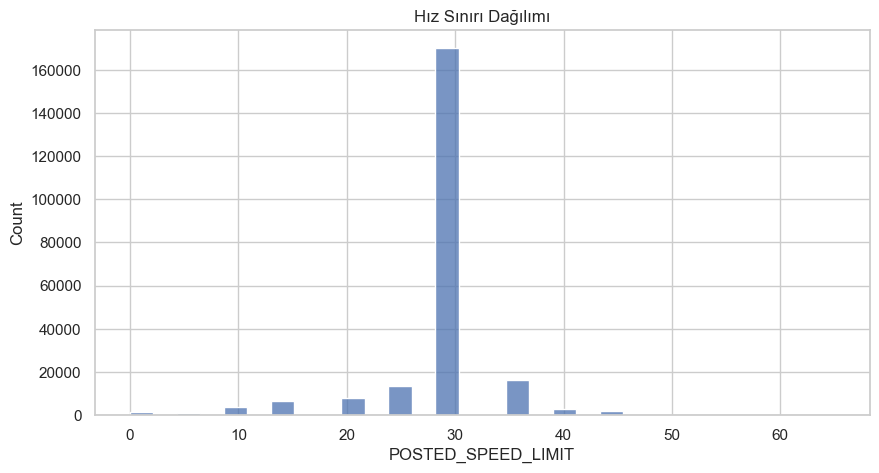

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(X_train['POSTED_SPEED_LIMIT'], bins=30)
plt.title("Hız Sınırı Dağılımı")
plt.show()

<h5>Kaza saatlerine göre yaralanma şiddetini gruplar ve dağılımını çubuk grafikte görselleştirir.</h5>

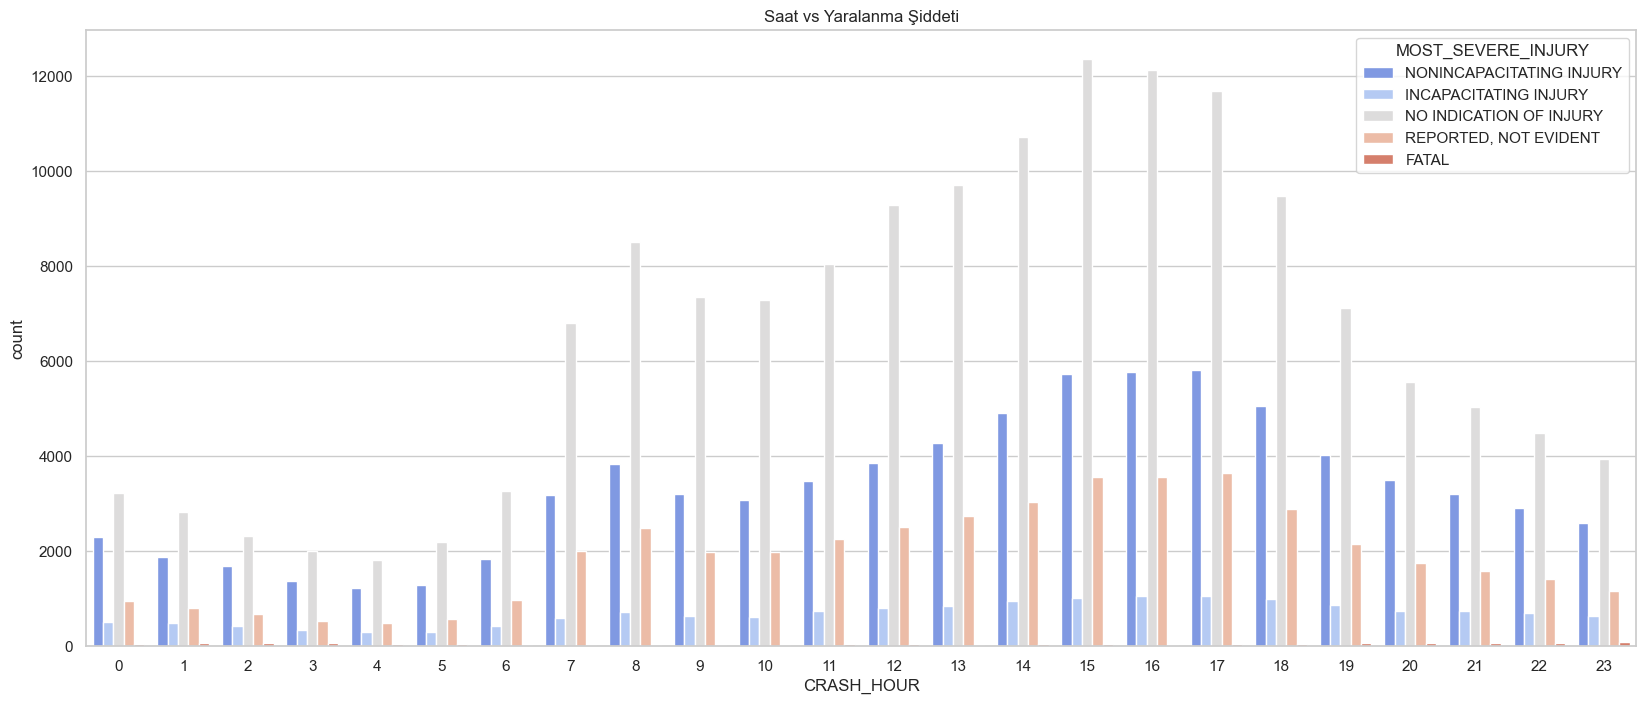

In [20]:
plt.figure(figsize=(20, 8))
sns.countplot(x='CRASH_HOUR', hue='MOST_SEVERE_INJURY', data=df, palette='coolwarm')
plt.title("Saat vs Yaralanma Şiddeti")
plt.show()


<h5>Işık koşulları ile yaralanma şiddeti arasındaki ilişkiyi heatmap (ısı haritası) ile görselleştirir.</h5>

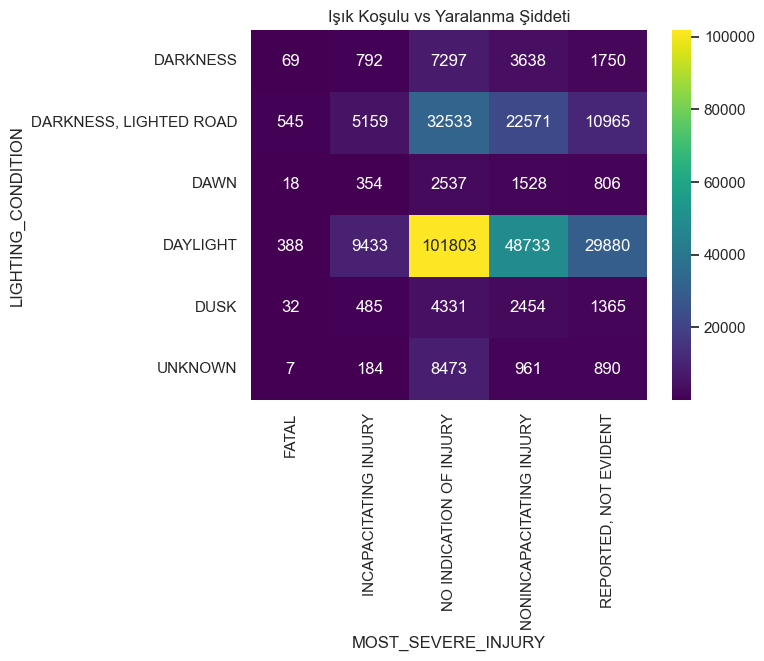

In [21]:
cross = df.groupby(['LIGHTING_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
sns.heatmap(cross, annot=True, fmt='d', cmap='viridis')
plt.title("Işık Koşulu vs Yaralanma Şiddeti")
plt.show()

<h5>Veri setindeki sütunları sayısal ve kategorik olarak ayırır, hedef değişkeni listelerden çıkarır ve sütun sayılarını ekrana yazdırır.</h5>

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# sayısal ve kategorik sütunları belirlenmesi
sayisal_sutunlar = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = df.select_dtypes(include=['object']).columns.tolist()
# Hedef değişken sayısal listeden çıkarılıyor
if 'MOST_SEVERE_INJURY' in sayisal_sutunlar:
    sayisal_sutunlar.remove('MOST_SEVERE_INJURY')
if 'MOST_SEVERE_INJURY' in kategorik_sutunlar:
    kategorik_sutunlar.remove('MOST_SEVERE_INJURY')

print("Sayısal sütun sayısı:", len(sayisal_sutunlar))
print("Kategorik sütun sayısı:", len(kategorik_sutunlar))


Sayısal sütun sayısı: 5
Kategorik sütun sayısı: 13


<h5>En yüksek varyansa sahip 4 sayısal sütunu seçer ve hedef değişkenle ilişkilerini boxplot grafikleriyle görselleştirir.</h5>

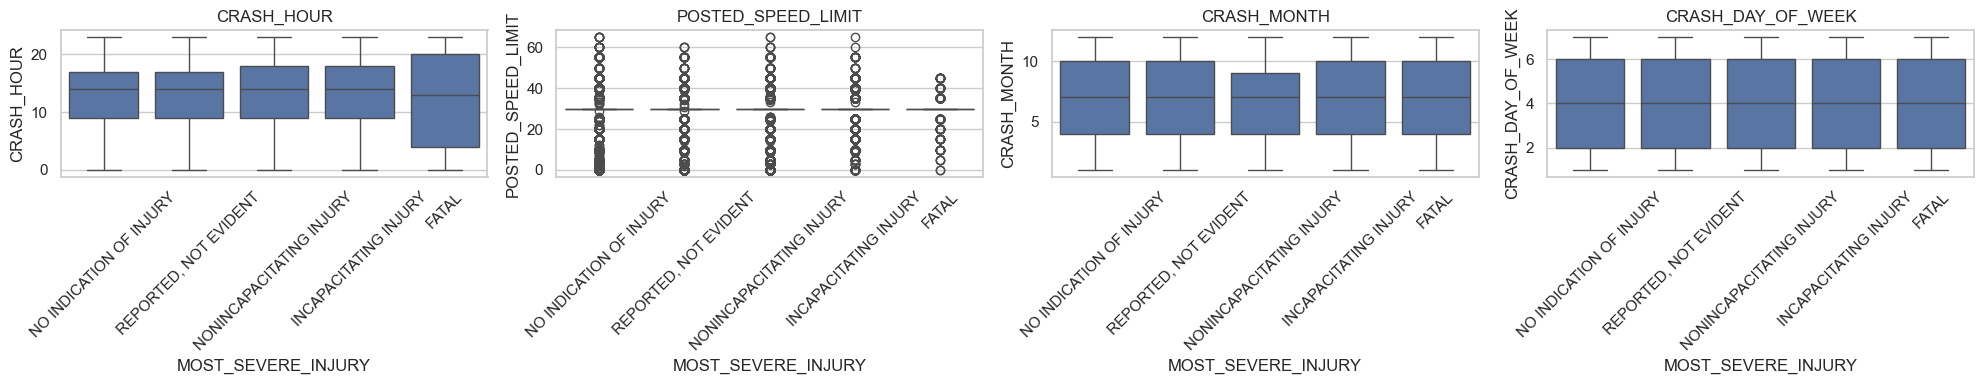

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_box_df = X_train.copy()
train_box_df["MOST_SEVERE_INJURY"] = y_train.values 

num_cols = train_box_df.select_dtypes(include=[np.number]).columns

var_series = train_box_df[num_cols].var().sort_values(ascending=False)
top_num_for_box = var_series.head(4).index

fig, axes = plt.subplots(1, len(top_num_for_box), figsize=(5 * len(top_num_for_box), 4))
if len(top_num_for_box) == 1:
    axes = [axes]

for ax, col in zip(axes, top_num_for_box):
    sns.boxplot(data=train_box_df, x="MOST_SEVERE_INJURY", y=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<h5>Tüm sayısal sütunlar için ayrı ayrı boxplot çizerek uç değer (outlier) analizini görselleştirir.</h5>

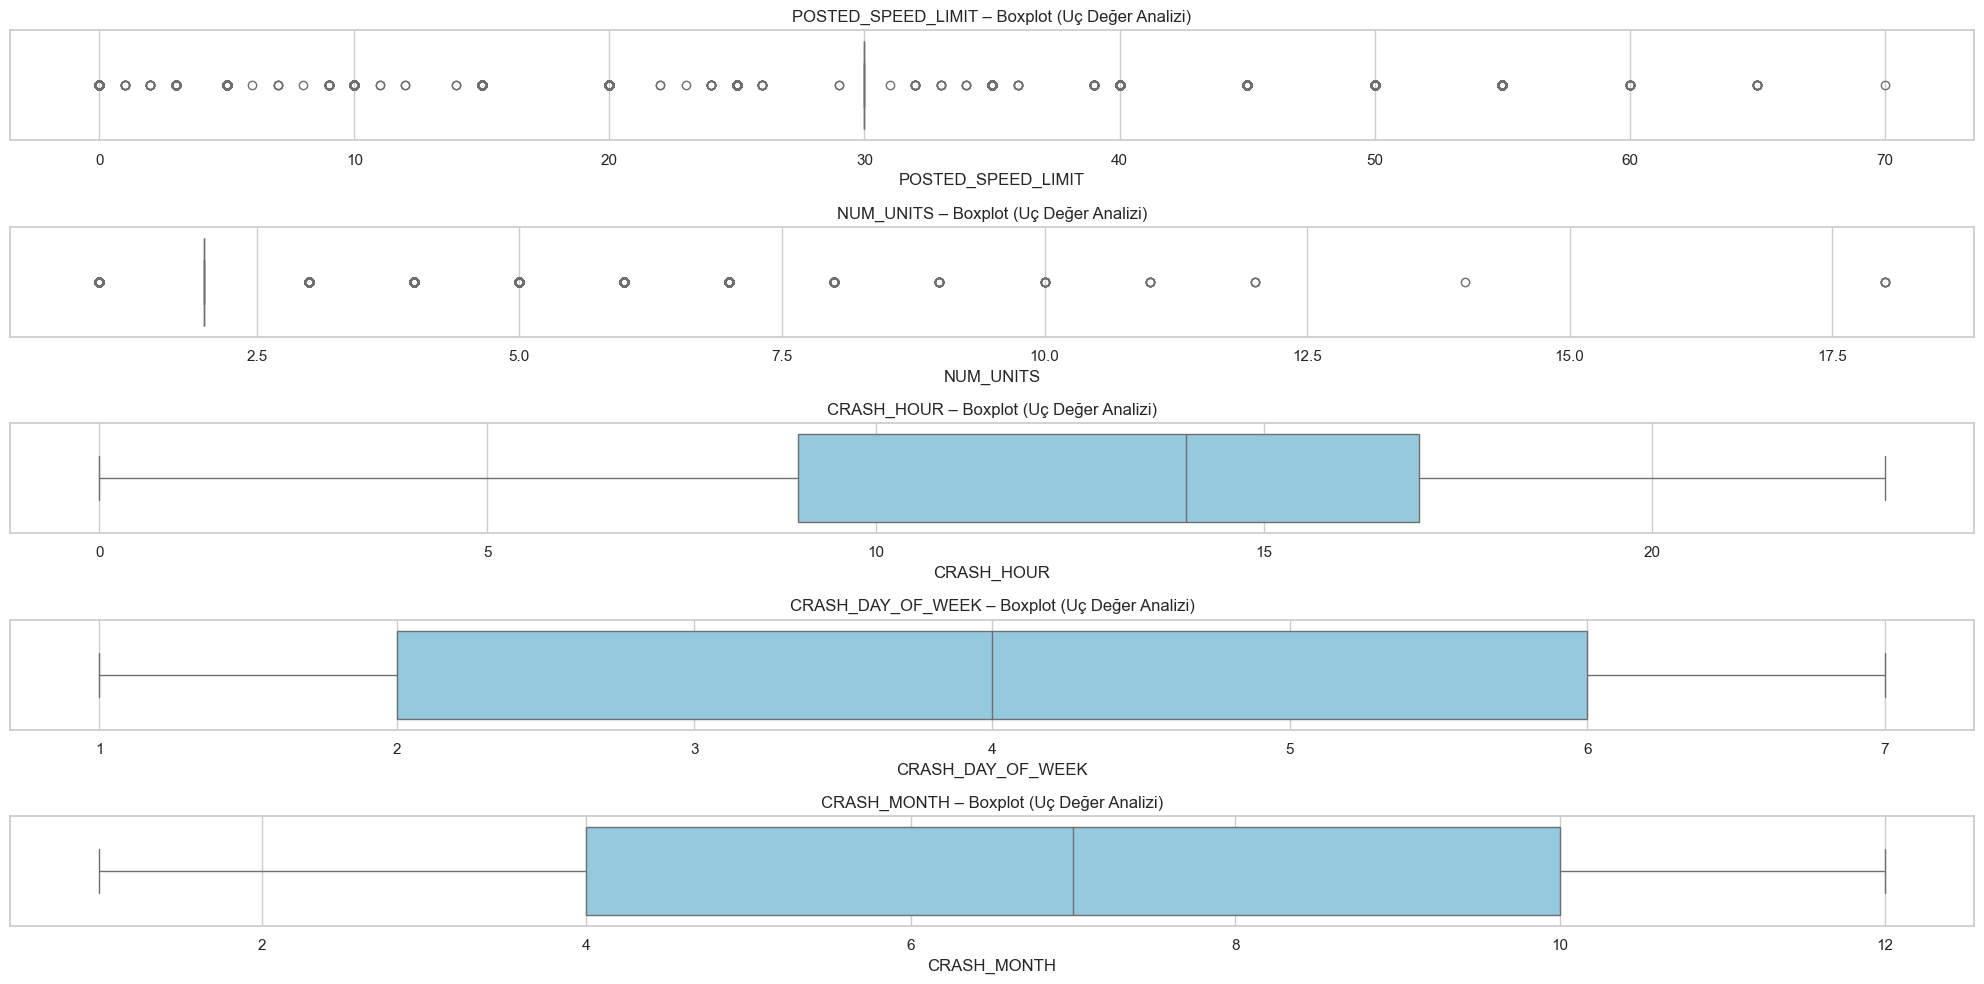

In [24]:
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"{col} – Boxplot (Uç Değer Analizi)", fontsize=12)

plt.tight_layout()
plt.show()

<h5>Train veri setindeki tüm sayısal sütunlarda aykırı değer oranını hesaplar ve en yüksek 10 sütunu listeler.</h5>

In [25]:
outlier_report = {}
num_cols = X_train.select_dtypes(include=[np.number]).columns
for c in num_cols:
    q1 = X_train[c].quantile(0.25)
    q3 = X_train[c].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outlier_rate = ((X_train[c] < lower) | (X_train[c] > upper)).mean() * 100
    outlier_report[c] = round(outlier_rate, 2)

outlier_df = pd.DataFrame(list(outlier_report.items()), columns=["Sütun", "Aykırı Değer Oranı (%)"])
outlier_df = outlier_df.sort_values(by="Aykırı Değer Oranı (%)", ascending=False)

print("\nAykırı değer oranı en yüksek sütunlar:")
print(outlier_df.head(10))


Aykırı değer oranı en yüksek sütunlar:
                Sütun  Aykırı Değer Oranı (%)
0  POSTED_SPEED_LIMIT                   24.46
1           NUM_UNITS                   15.27
2          CRASH_HOUR                    0.00
3   CRASH_DAY_OF_WEEK                    0.00
4         CRASH_MONTH                    0.00


<h5>Tüm sayısal sütunlar için histogram + KDE grafiği çizerek dağılımı görselleştirir.</h5>

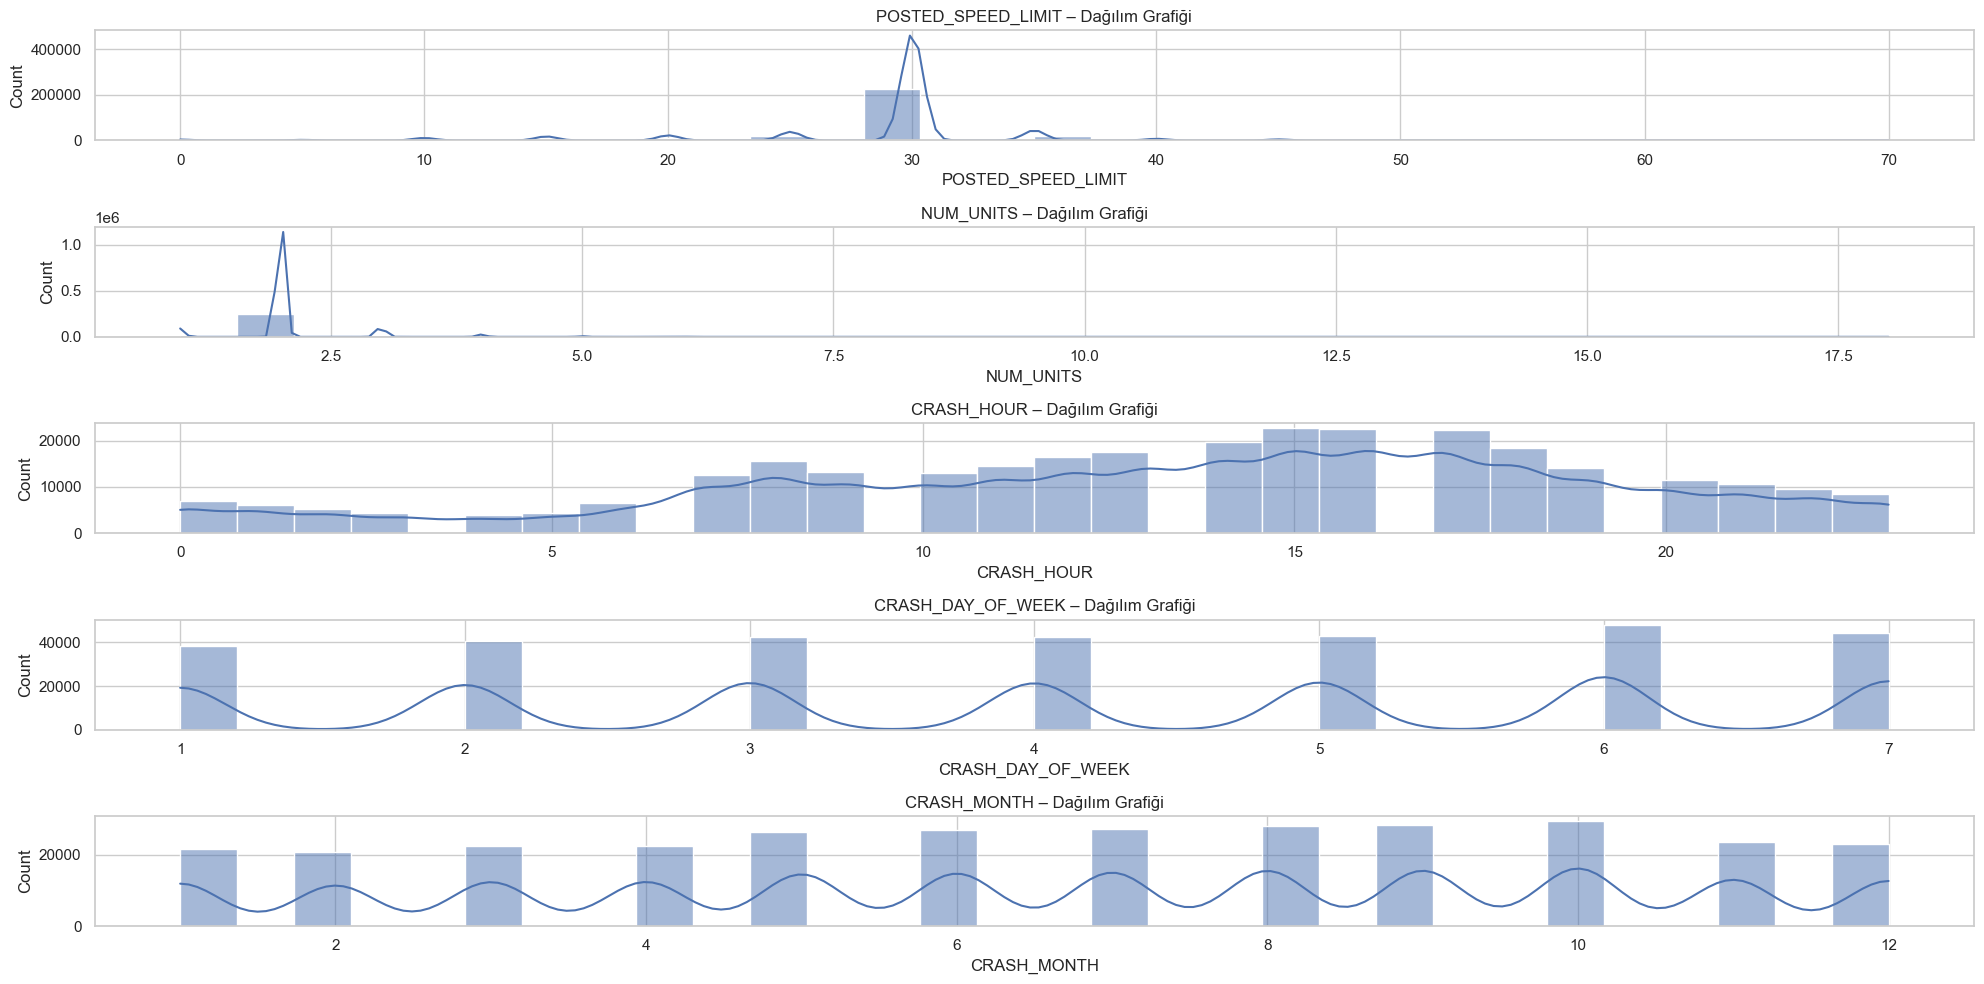

In [26]:
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"{col} – Dağılım Grafiği", fontsize=12)

plt.tight_layout()
plt.show()

<h5>Train veri setindeki sayısal sütunlar arasındaki korelasyonu hesaplar ve heatmap ile görselleştirir.</h5>

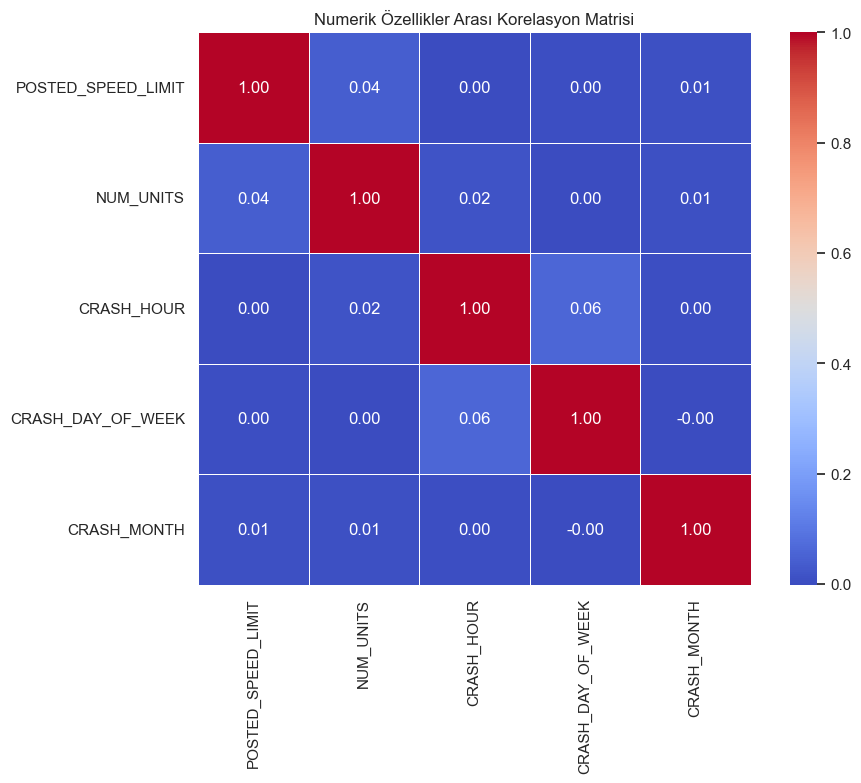

In [27]:
# 1) Sadece numerik sütunları al
X_train_num_corr = X_train[sayisal_sutunlar].copy()

# 2) Korelasyon matrisi hesapla (varsayılan = Pearson)
corr_matrix = X_train_num_corr.corr()

# 3) Korelasyon matrisini görselleştir (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # Hücrelere korelasyon değerini yaz
    fmt=".2f",            # 2 basamak göster
    cmap="coolwarm",      # Renk paleti
    square=True,
    linewidths=0.5
)
plt.title("Numerik Özellikler Arası Korelasyon Matrisi")
plt.tight_layout()
plt.show()

<h5>Veri yapısı hakkında bilgi verir.</h5>

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299981 entries, 0 to 299999
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   POSTED_SPEED_LIMIT       299981 non-null  int64 
 1   TRAFFIC_CONTROL_DEVICE   299981 non-null  object
 2   DEVICE_CONDITION         299981 non-null  object
 3   WEATHER_CONDITION        299981 non-null  object
 4   LIGHTING_CONDITION       299981 non-null  object
 5   FIRST_CRASH_TYPE         299981 non-null  object
 6   TRAFFICWAY_TYPE          299981 non-null  object
 7   ALIGNMENT                299981 non-null  object
 8   ROADWAY_SURFACE_COND     299981 non-null  object
 9   ROAD_DEFECT              299981 non-null  object
 10  CRASH_TYPE               299981 non-null  object
 11  DAMAGE                   299981 non-null  object
 12  PRIM_CONTRIBUTORY_CAUSE  299981 non-null  object
 13  SEC_CONTRIBUTORY_CAUSE   299981 non-null  object
 14  NUM_UNITS                

<h5>Linear SVC modeli için ön işleme pipeline kurar, modeli eğitir ve validation/test setlerinde performans raporu üretir.</h5>

In [29]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
# Ön işleme pipeline (sadece imputation + encoding + scaling)
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, sayisal_sutunlar),
    ('cat', cat_transformer, kategorik_sutunlar)
])

# Linear SVC modeli (dengesiz veri için class_weight='balanced')
svc_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(random_state=42, class_weight='balanced'))
])

# Eğitim
svc_model.fit(X_train, y_train)

# Validation set üzerinde tahmin
y_val_pred = svc_model.predict(X_val)

# Performans raporu
print("\n--- Validation Sonuçları ---")
print(classification_report(y_val, y_val_pred))


# Test set üzerinde değerlendirme
y_test_pred = svc_model.predict(X_test)
print("\n--- Test Sonuçları ---")
print(classification_report(y_test, y_test_pred))


--- Validation Sonuçları ---
                          precision    recall  f1-score   support

                   FATAL       0.03      0.60      0.06        53
   INCAPACITATING INJURY       0.16      0.02      0.03       820
 NO INDICATION OF INJURY       1.00      0.86      0.93      7849
NONINCAPACITATING INJURY       0.53      0.60      0.56      3994
   REPORTED, NOT EVIDENT       0.42      0.47      0.44      2283

                accuracy                           0.69     14999
               macro avg       0.43      0.51      0.40     14999
            weighted avg       0.74      0.69      0.70     14999


--- Test Sonuçları ---
                          precision    recall  f1-score   support

                   FATAL       0.03      0.49      0.05       212
   INCAPACITATING INJURY       0.17      0.02      0.03      3282
 NO INDICATION OF INJURY       1.00      0.85      0.92     31395
NONINCAPACITATING INJURY       0.53      0.61      0.57     15977
   REPORTED, NOT E

<h5>Validation ve test setleri için confusion matrix (karışıklık matrisi) oluşturur ve heatmap ile görselleştirir.</h5>

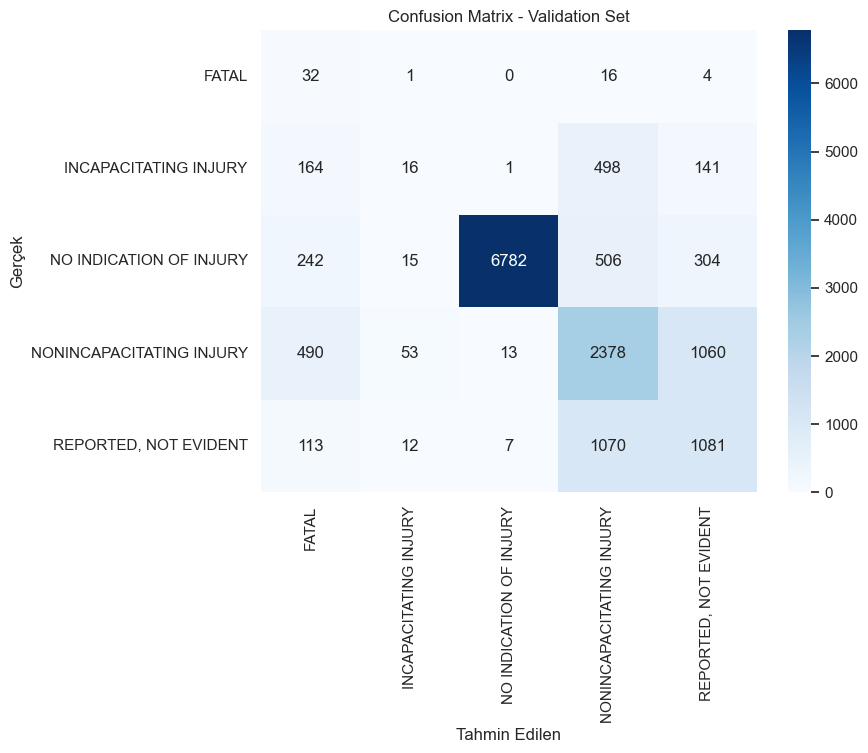

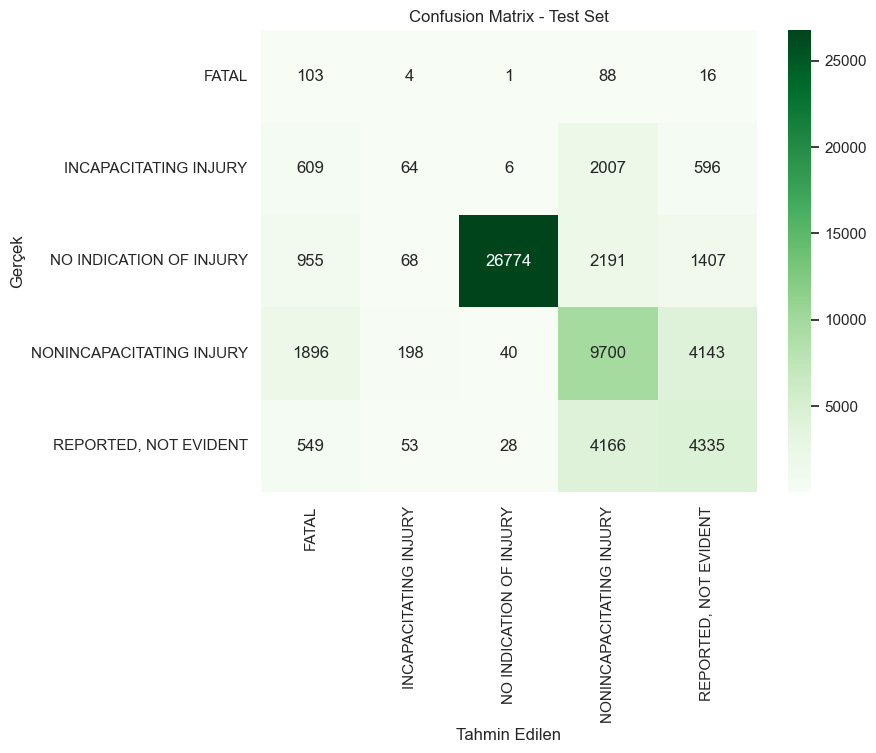

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix (Validation set)
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_val),
            yticklabels=np.unique(y_val))
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# Confusion Matrix (Test set)
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

<h5>Özellik seçimi (SelectKBest, VarianceThreshold), pipeline kurulumu, LinearSVC modeli ve performans görselleştirme için gerekli modüller yükleniyor.</h5>

In [31]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

<h5>Özellik seçimi için iki adım tanımlar: düşük varyanslı sütunları kaldırma ve en anlamlı 50 özelliği seçme.</h5>

In [32]:
# Düşük varyanslı özellikleri kaldır
var_thresh = VarianceThreshold(threshold=0.01)

# En anlamlı 50 özelliği mutual information ile seç
feature_selector = SelectKBest(mutual_info_classif, k=50)

<h5>Ön işleme, düşük varyans filtreleme, en anlamlı özellik seçimi ve Linear SVC sınıflandırıcısını tek bir pipeline içinde birleştirir.</h5>

In [33]:
svc_model_fs = Pipeline([
    ('preprocessor', preprocessor),  
    ('var_thresh', var_thresh),
    ('feature_selection', feature_selector),
    ('classifier', LinearSVC(random_state=42, class_weight='balanced'))
])

<h5>Özellik seçimi eklenmiş pipeline’ı eğitir ve validation setinde sınıflandırma raporu üretir.</h5>

In [34]:
svc_model_fs.fit(X_train, y_train)

y_val_pred_fs = svc_model_fs.predict(X_val)
print("\n--- Validation Sonuçları (VarianceThreshold + SelectKBest) ---")
print(classification_report(y_val, y_val_pred_fs))


--- Validation Sonuçları (VarianceThreshold + SelectKBest) ---
                          precision    recall  f1-score   support

                   FATAL       0.02      0.49      0.05        53
   INCAPACITATING INJURY       0.44      0.00      0.01       820
 NO INDICATION OF INJURY       1.00      0.86      0.93      7849
NONINCAPACITATING INJURY       0.53      0.62      0.57      3994
   REPORTED, NOT EVIDENT       0.42      0.46      0.44      2283

                accuracy                           0.69     14999
               macro avg       0.48      0.49      0.40     14999
            weighted avg       0.75      0.69      0.70     14999



<h5>Özellik seçimi eklenmiş pipeline ile test setinde tahmin yapar ve sınıflandırma raporu üretir.</h5>

In [35]:
y_test_pred_fs = svc_model_fs.predict(X_test)
print("\n--- Test Sonuçları (VarianceThreshold + SelectKBest) ---")
print(classification_report(y_test, y_test_pred_fs))


--- Test Sonuçları (VarianceThreshold + SelectKBest) ---
                          precision    recall  f1-score   support

                   FATAL       0.02      0.43      0.04       212
   INCAPACITATING INJURY       0.21      0.00      0.01      3282
 NO INDICATION OF INJURY       1.00      0.85      0.92     31395
NONINCAPACITATING INJURY       0.53      0.63      0.57     15977
   REPORTED, NOT EVIDENT       0.41      0.45      0.43      9131

                accuracy                           0.68     59997
               macro avg       0.43      0.47      0.39     59997
            weighted avg       0.74      0.68      0.70     59997



<h5>Özellik seçimi (FS + VT) sonrası validation ve test setleri için confusion matrix oluşturur ve heatmap ile görselleştirir.</h5>

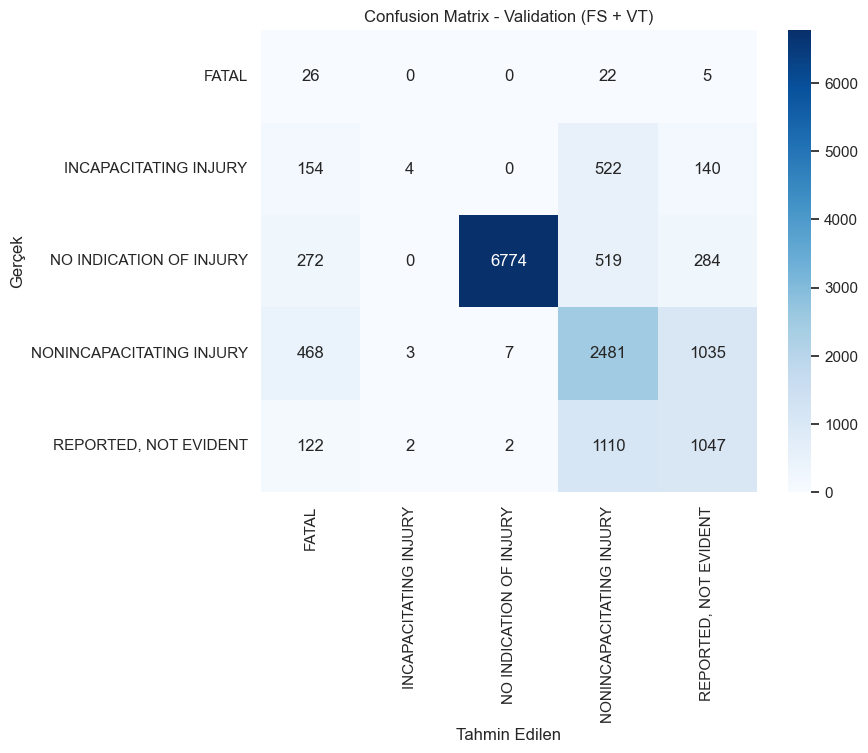

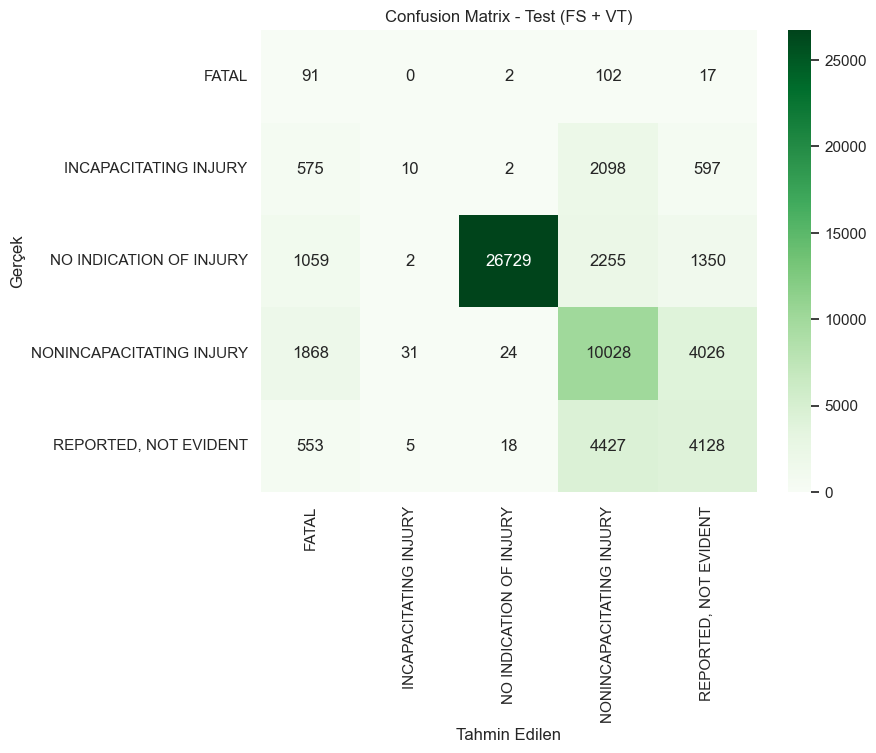

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix (Validation set - FS+VT)
cm_val_fs = confusion_matrix(y_val, y_val_pred_fs)

plt.figure(figsize=(8,6))
sns.heatmap(cm_val_fs, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_val),
            yticklabels=np.unique(y_val))
plt.title("Confusion Matrix - Validation (FS + VT)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

# Confusion Matrix (Test set - FS+VT)
cm_test_fs = confusion_matrix(y_test, y_test_pred_fs)

plt.figure(figsize=(8,6))
sns.heatmap(cm_test_fs, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - Test (FS + VT)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

<h5>Base model ile FS+VT (VarianceThreshold + SelectKBest) modelinin validation ve test performanslarını karşılaştıran tablo üretir.</h5>

In [37]:
import pandas as pd
from sklearn.metrics import classification_report

# Base model sonuçları
y_val_pred_base = svc_model.predict(X_val)
y_test_pred_base = svc_model.predict(X_test)

report_val_base = classification_report(y_val, y_val_pred_base, output_dict=True)
report_test_base = classification_report(y_test, y_test_pred_base, output_dict=True)

# FS+VT model sonuçları
y_val_pred_fs = svc_model_fs.predict(X_val)
y_test_pred_fs = svc_model_fs.predict(X_test)

report_val_fs = classification_report(y_val, y_val_pred_fs, output_dict=True)
report_test_fs = classification_report(y_test, y_test_pred_fs, output_dict=True)

# Karşılaştırma tablosu (satırlar modeller, sütunlar metrikler)
comparison = pd.DataFrame({
    'Validation Accuracy': [report_val_base['accuracy'], report_val_fs['accuracy']],
    'Validation Macro F1': [report_val_base['macro avg']['f1-score'], report_val_fs['macro avg']['f1-score']],
    'Test Accuracy': [report_test_base['accuracy'], report_test_fs['accuracy']],
    'Test Macro F1': [report_test_base['macro avg']['f1-score'], report_test_fs['macro avg']['f1-score']]
}, index=['Base Model', 'FS+VT Model'])

# Tabloyu yazdır
print("\n--- Model Karşılaştırma Tablosu ---")
print(comparison.to_string())


--- Model Karşılaştırma Tablosu ---
             Validation Accuracy  Validation Macro F1  Test Accuracy  Test Macro F1
Base Model              0.685979             0.404971       0.682967       0.402410
FS+VT Model             0.688846             0.398725       0.683134       0.394111


<h3>Gradient Boosting Classifier</h3>
Bu çalışmada ele alınan yaralanma şiddeti tahmini problemi, çok sayıda sayısal ve kategorik değişken içeren, doğrusal olmayan ilişkiler barındıran ve sınıf dağılımı dengesiz olan bir tabular veri yapısına sahiptir. Bu tür problemlerde doğrusal modeller, değişkenler arasındaki karmaşık etkileşimleri yeterince temsil edememektedir.

Gradient Boosting Classifier, zayıf öğreniciler olarak kullanılan karar ağaçlarını ardışık biçimde eğiterek önceki adımlarda yapılan hataları minimize etmeyi amaçlayan güçlü bir ensemble öğrenme yöntemidir. Model, doğrusal olmayan ilişkileri ve özellik etkileşimlerini etkin biçimde öğrenebilmekte, aynı zamanda aykırı değerlere karşı görece dayanıklı bir yapı sunmaktadır. Bu özellikleri sayesinde, trafik kazaları gibi çok faktörlü ve karmaşık problemlerde yüksek genelleme başarımı sağlamaktadır.

Bu nedenlerle Gradient Boosting Classifier, çalışmada ana (non-linear) modellerden biri olarak tercih edilmiştir.

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


Ön işleme adımları ile Gradient Boosting sınıflandırıcısını tek bir pipeline içinde birleştirerek modelleme sürecini tutarlı hale getirir.

In [39]:
gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        random_state=42
    ))
])


Gradient Boosting modelini eğitim verisi (X_train, y_train) üzerinde eğitir.

In [40]:
gb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'NUM_UNITS', 'CRASH_HOUR',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_MONTH']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT', 'CRASH_TYPE',
                                                   'DAMAGE',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

Eğitilen Gradient Boosting modeli ile doğrulama verisi üzerinde tahmin yapar ve modelin sınıf bazlı performansını özetleyen değerlendirme raporunu üretir.

In [41]:
y_val_pred_gb = gb_model.predict(X_val)
print(classification_report(y_val, y_val_pred_gb))


                          precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        53
   INCAPACITATING INJURY       0.00      0.00      0.00       820
 NO INDICATION OF INJURY       0.96      0.89      0.93      7849
NONINCAPACITATING INJURY       0.51      0.85      0.64      3994
   REPORTED, NOT EVIDENT       0.50      0.24      0.32      2283

                accuracy                           0.73     14999
               macro avg       0.40      0.40      0.38     14999
            weighted avg       0.72      0.73      0.70     14999



Eğitilen Gradient Boosting modeli kullanılarak test verisi üzerinde tahmin yapılır ve modelin gerçek veri üzerindeki performansı sınıf bazlı metriklerle raporlanır.

In [42]:
y_test_pred_gb = gb_model.predict(X_test)
print(classification_report(y_test, y_test_pred_gb))


                          precision    recall  f1-score   support

                   FATAL       0.19      0.02      0.03       212
   INCAPACITATING INJURY       0.30      0.00      0.00      3282
 NO INDICATION OF INJURY       0.96      0.88      0.92     31395
NONINCAPACITATING INJURY       0.51      0.86      0.64     15977
   REPORTED, NOT EVIDENT       0.51      0.23      0.31      9131

                accuracy                           0.73     59997
               macro avg       0.49      0.40      0.38     59997
            weighted avg       0.73      0.73      0.70     59997



In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


Eğitilmiş Gradient Boosting modeli ile test verisi için tahmin sonuçları üretilir.

In [44]:
y_test_pred_gb = gb_model.predict(X_test)



Gerçek ve tahmin edilen test etiketlerini karşılaştırarak Gradient Boosting modeline ait karmaşıklık (confusion) matrisini oluşturur.

In [45]:
cm_test_gb = confusion_matrix(y_test, y_test_pred_gb)


Test verisinde ve model tahminlerinde yer alan tüm sınıf etiketlerini belirleyerek karmaşıklık matrisinin eksiksiz ve doğru şekilde etiketlenmesini sağlar.

In [46]:
labels = np.unique(np.concatenate([np.array(y_test), np.array(y_test_pred_gb)]))


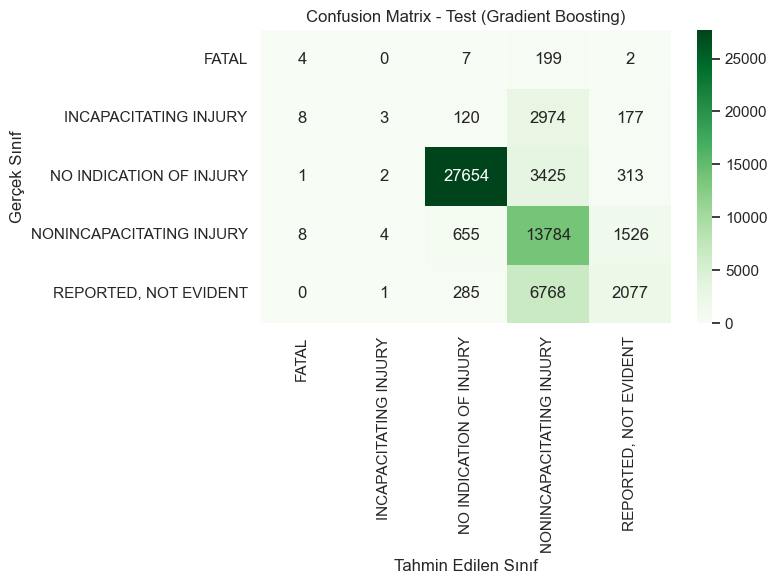

In [47]:
plt.figure(figsize=(8,6))
sns.heatmap(
    cm_test_gb,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Confusion Matrix - Test (Gradient Boosting)")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()


Gradient Boosting modelinin ve pipeline içindeki tüm bileşenlerin mevcut hiperparametrelerini görüntüler.

In [48]:
gb_model.get_params()


{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    ['POSTED_SPEED_LIMIT', 'NUM_UNITS',
                                     'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
                                     'CRASH_MONTH']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('encoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                                 

Gradient Boosting modelinin temel hiperparametrelerini ayarlayarak modelin öğrenme kapasitesini ve genelleme performansını kontrol eder.

In [49]:
gb_model.set_params(
    classifier__n_estimators=400,
    classifier__learning_rate=0.05,
    classifier__subsample=0.8,
    classifier__max_depth=3
)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'NUM_UNITS', 'CRASH_HOUR',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_MONTH']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT', 'CRASH_TYPE',
                                                   'DAMAGE',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=400, random_state=42,
                                            subsample=0.8))])

Güncellenmiş hiperparametrelerle Gradient Boosting modelini eğitim verisi üzerinde yeniden eğitir.

In [50]:
gb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'NUM_UNITS', 'CRASH_HOUR',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_MONTH']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT', 'CRASH_TYPE',
                                                   'DAMAGE',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=400, random_state=42,
                                            subsample=0.8))])

Güncellenmiş hiperparametrelerle eğitilen Gradient Boosting modelinin doğrulama ve test verileri üzerindeki sınıf bazlı performansını raporlar.

In [52]:
from sklearn.metrics import classification_report

y_val_pred_gb = gb_model.predict(X_val)
print("\n--- Validation (GB Updated Params) ---")
print(classification_report(y_val, y_val_pred_gb))

y_test_pred_gb = gb_model.predict(X_test)
print("\n--- Test (GB Updated Params) ---")
print(classification_report(y_test, y_test_pred_gb))



--- Validation (GB Updated Params) ---
                          precision    recall  f1-score   support

                   FATAL       0.00      0.00      0.00        53
   INCAPACITATING INJURY       0.00      0.00      0.00       820
 NO INDICATION OF INJURY       0.96      0.89      0.93      7849
NONINCAPACITATING INJURY       0.51      0.85      0.64      3994
   REPORTED, NOT EVIDENT       0.50      0.25      0.33      2283

                accuracy                           0.73     14999
               macro avg       0.40      0.40      0.38     14999
            weighted avg       0.72      0.73      0.71     14999


--- Test (GB Updated Params) ---
                          precision    recall  f1-score   support

                   FATAL       0.20      0.03      0.05       212
   INCAPACITATING INJURY       0.29      0.00      0.00      3282
 NO INDICATION OF INJURY       0.96      0.88      0.92     31395
NONINCAPACITATING INJURY       0.51      0.86      0.64     1597

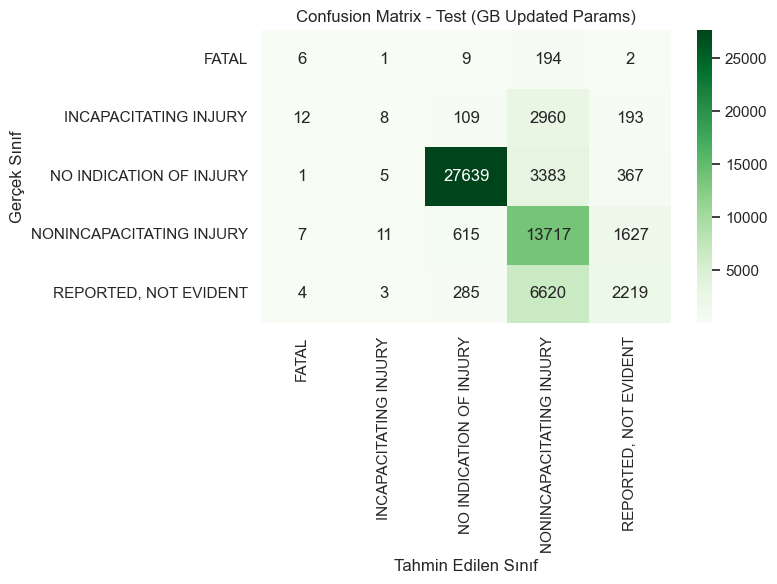

In [53]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm_test_gb = confusion_matrix(y_test, y_test_pred_gb)
labels = np.unique(np.concatenate([np.array(y_test), np.array(y_test_pred_gb)]))

plt.figure(figsize=(8,6))
sns.heatmap(cm_test_gb, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test (GB Updated Params)")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()


<h3>L1-Regularized Linear SVM (LinearSVC – L1 penalty)</h3>Bu veri seti çok sayıda kategorik değişken içerdiği için One-Hot Encoding sonrası özellik sayısı ciddi biçimde artmaktadır. Yüksek boyutlu bu yapıda doğrusal SVM modelleri hızlı ve güçlü bir baseline sağlar. L1 düzenlileştirme (L1 penalty) ise modele “seyreklik” kazandırarak gereksiz/etkisiz özelliklerin katsayılarını sıfıra itmekte, dolaylı olarak özellik seçimi yapmaktadır. Böylece model karmaşıklığı kontrol altına alınır, overfitting riski azalır ve model daha yorumlanabilir hale gelir. Ayrıca class_weight='balanced' kullanımıyla sınıf dengesizliğinin etkisi azaltılarak azınlık sınıfların öğrenilmesi desteklenir. Bu nedenlerle L1-Regularized LinearSVC, Gradient Boosting’e karşı güçlü ve açıklanabilir bir karşılaştırma modeli olarak seçilmiştir.

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


L1 düzenlileştirmeli LinearSVC kullanarak ön işleme adımlarıyla birlikte seyrek ve ayırt edici özellikler öğrenebilen bir sınıflandırma modeli oluşturur.

In [55]:
svm_l1_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(
        penalty='l1',
        dual=False,
        C=1.0,
        class_weight='balanced',
        random_state=42,
        max_iter=10000
    ))
])


L1 düzenlileştirmeli LinearSVC modelini eğitim verisi üzerinde eğitir.

In [56]:
svm_l1_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['POSTED_SPEED_LIMIT',
                                                   'NUM_UNITS', 'CRASH_HOUR',
                                                   'CRASH_DAY_OF_WEEK',
                                                   'CRASH_MONTH']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handl...
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
                                                   'TRAFFICWAY_TYPE',
                                                   'ALIGNMENT',
                                                   'ROADWAY_SURFACE_COND',
                                                   'ROAD_DEFECT', 'CRASH_TYPE',
                                                   'DAMAGE',
                                                   'PRIM_CONTRIBUTORY_CAUSE',
                                                   'SEC_CONTRIBUTORY_CAUSE'])])),
                ('classifier',
                 LinearSVC(class_weight='balanced', dual=False, max_iter=10000,
                           penalty='l1', random_state=42))])

Eğitilen LinearSVC (L1) modeliyle doğrulama verisi üzerinde tahmin yaparak sınıf bazlı performansını raporlar.

In [57]:
y_val_pred_svm = svm_l1_model.predict(X_val)
print("\n--- Validation (LinearSVC L1) ---")
print(classification_report(y_val, y_val_pred_svm))



--- Validation (LinearSVC L1) ---
                          precision    recall  f1-score   support

                   FATAL       0.03      0.60      0.06        53
   INCAPACITATING INJURY       0.17      0.02      0.03       820
 NO INDICATION OF INJURY       1.00      0.86      0.93      7849
NONINCAPACITATING INJURY       0.53      0.60      0.56      3994
   REPORTED, NOT EVIDENT       0.42      0.47      0.44      2283

                accuracy                           0.69     14999
               macro avg       0.43      0.51      0.41     14999
            weighted avg       0.74      0.69      0.70     14999



Eğitilen LinearSVC (L1) modeli kullanılarak test verisi üzerinde tahmin yapılır ve modelin genel performansı sınıf bazlı metriklerle değerlendirilir.

In [58]:
y_test_pred_svm = svm_l1_model.predict(X_test)
print("\n--- Test (LinearSVC L1) ---")
print(classification_report(y_test, y_test_pred_svm))



--- Test (LinearSVC L1) ---
                          precision    recall  f1-score   support

                   FATAL       0.02      0.48      0.05       212
   INCAPACITATING INJURY       0.17      0.02      0.03      3282
 NO INDICATION OF INJURY       1.00      0.85      0.92     31395
NONINCAPACITATING INJURY       0.53      0.61      0.57     15977
   REPORTED, NOT EVIDENT       0.41      0.47      0.44      9131

                accuracy                           0.68     59997
               macro avg       0.43      0.49      0.40     59997
            weighted avg       0.74      0.68      0.70     59997



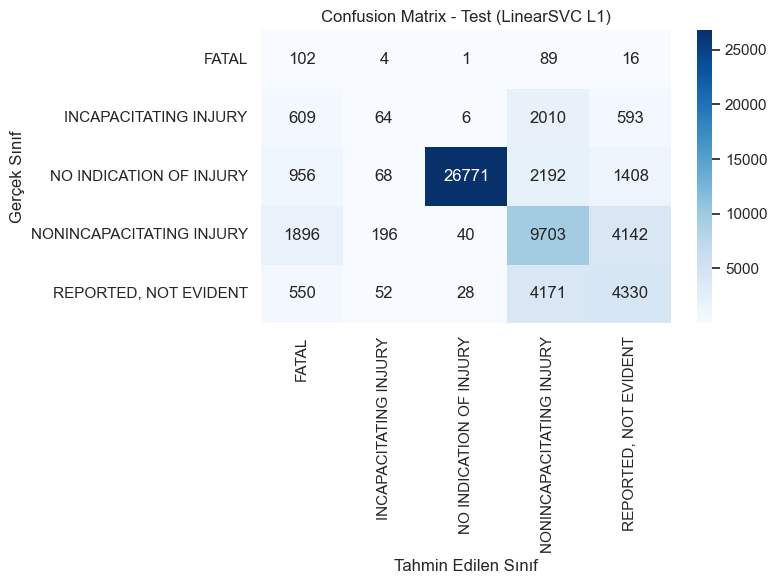

In [59]:
cm_test_svm = confusion_matrix(y_test, y_test_pred_svm)
labels = np.unique(np.concatenate([np.array(y_test), np.array(y_test_pred_svm)]))

plt.figure(figsize=(8,6))
sns.heatmap(cm_test_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test (LinearSVC L1)")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()


FATAL: Model, veri setinde nadir görülmesine rağmen fatal kazaları anlamlı bir oranda doğru tahmin etmiş, ancak bazı vakalarda şiddeti daha düşük yaralanma sınıflarına kaydırma eğilimi göstermiştir.

INCAPACITATING INJURY: Bu sınıf, hem daha ağır hem de daha hafif yaralanma seviyeleriyle örtüşmesi nedeniyle model tarafından en çok karıştırılan sınıflardan biri olmuş, buna rağmen tamamen göz ardı edilmemiştir.

NO INDICATION OF INJURY: Veri setinin en baskın ve net tanımlı sınıfı olan bu kategoride LinearSVC oldukça yüksek doğruluk sağlayarak modelin genel performansını stabilize etmiştir.

NONINCAPACITATING INJURY: Model bu sınıfı makul düzeyde öğrenmiş, ancak tanımsal benzerlik nedeniyle özellikle “Reported, Not Evident” sınıfıyla karışmalar gözlenmiştir.

REPORTED, NOT EVIDENT: Bu sınıfta modelin performansı orta seviyede kalmış ve belirsiz raporlama yapısı nedeniyle tahminlerin önemli bir kısmı hafif yaralanma sınıfına yönelmiştir.

LinearSVC modeli için düzenlileştirme parametresi (C) üzerinde yeterli düzeyde hyperparametre ayarlaması yapılması, özellikle azınlık sınıfların duyarlılığını artırabilir. Ancak modelin doğrusal yapısı nedeniyle elde edilecek iyileşme belirli bir seviyenin ötesine geçememektedir.

In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score
from IPython.display import display  # tabloyu düzgün göstermek için

FATAL_LABEL = "FATAL"
INCAP_LABEL = "INCAPACITATING INJURY"

def safe_recall(y_true, y_pred, label):
    y_true = pd.Series(y_true)
    if label not in set(y_true.unique()):
        return np.nan
    return recall_score(y_true, y_pred, labels=[label], average=None, zero_division=0)[0]


In [62]:
models_in_order = [
    ("Baseline (LinearSVC)", svc_model),
    ("Baseline + FS&VT (LinearSVC)", svc_model_fs),
    ("Gradient Boosting", gb_model),
    ("LinearSVC (L1)", svm_l1_model),
]


Farklı modellerin doğrulama ve test performans metriklerini hesaplayarak sonuçları karşılaştırmalı analiz için tek bir tablo (DataFrame) halinde toplar.

In [63]:
rows = []

for name, model in models_in_order:
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    rows.append({
        "Model": name,

        "Val Acc": accuracy_score(y_val, y_val_pred),
        "Val Macro F1": f1_score(y_val, y_val_pred, average="macro", zero_division=0),
        "Val Weighted F1": f1_score(y_val, y_val_pred, average="weighted", zero_division=0),
        "Val FATAL Rec": safe_recall(y_val, y_val_pred, FATAL_LABEL),
        "Val INCAP Rec": safe_recall(y_val, y_val_pred, INCAP_LABEL),

        "Test Acc": accuracy_score(y_test, y_test_pred),
        "Test Macro F1": f1_score(y_test, y_test_pred, average="macro", zero_division=0),
        "Test Weighted F1": f1_score(y_test, y_test_pred, average="weighted", zero_division=0),
        "Test FATAL Rec": safe_recall(y_test, y_test_pred, FATAL_LABEL),
        "Test INCAP Rec": safe_recall(y_test, y_test_pred, INCAP_LABEL),
    })

comparison_df = pd.DataFrame(rows).set_index("Model")


In [67]:
val_table = comparison_df[
    ["Val Acc", "Val Macro F1", "Val Weighted F1", "Val FATAL Rec", "Val INCAP Rec"]
].round(3)

print("=== VALIDATION SONUÇLARI ===")
display(val_table)



=== VALIDATION SONUÇLARI ===


,Val Acc,Val Macro F1,Val Weighted F1,Val FATAL Rec,Val INCAP Rec
Model,,,,,
Baseline (LinearSVC),0.686,0.405,0.704,0.604,0.020
Baseline + FS&VT (LinearSVC),0.689,0.399,0.705,0.491,0.005
Gradient Boosting,0.730,0.380,0.706,0.000,0.000
LinearSVC (L1),0.686,0.405,0.704,0.604,0.020


Validation sonuçlarında Gradient Boosting modeli en yüksek doğruluğu (%0.73) elde etmesine rağmen FATAL ve INCAP sınıflarını hiç yakalayamamıştır. Baseline LinearSVC ve LinearSVC (L1) modelleri benzer ve daha dengeli performans göstermiş, özellikle FATAL sınıfında daha anlamlı recall değerleri üretmiştir. FS+VT eklenmesi genel performansta belirgin bir iyileşme sağlamamıştır.

In [70]:
test_cols = ["Test Acc", "Test Macro F1", "Test Weighted F1", "Test FATAL Rec", "Test INCAP Rec"]
print("=== TEST SONUÇLARI ===")
display(comparison_df[test_cols].round(3))


=== TEST SONUÇLARI ===


,Test Acc,Test Macro F1,Test Weighted F1,Test FATAL Rec,Test INCAP Rec
Model,,,,,
Baseline (LinearSVC),0.683,0.402,0.702,0.486,0.020
Baseline + FS&VT (LinearSVC),0.683,0.394,0.700,0.429,0.003
Gradient Boosting,0.727,0.389,0.702,0.028,0.002
LinearSVC (L1),0.683,0.402,0.702,0.481,0.020


Test sonuçlarında Gradient Boosting modeli en yüksek doğruluğa (%0.727) ulaşsa da FATAL ve INCAP sınıflarını neredeyse hiç yakalayamamıştır. Baseline LinearSVC ve LinearSVC (L1) modelleri benzer ve daha dengeli performans göstererek özellikle FATAL sınıfında daha yüksek recall değerleri elde etmiştir. FS+VT yaklaşımı test aşamasında da belirgin bir iyileşme sağlamamıştır.

<h2>Genel Çıkarım</h2>

Bu çalışmada yaralanma şiddeti tahmini için farklı sınıflandırma modelleri karşılaştırılmıştır. Sonuçlar, yüksek doğruluk (accuracy) değerlerinin tek başına model başarısını değerlendirmek için yeterli olmadığını açıkça göstermektedir. Özellikle veri setindeki ciddi sınıf dengesizliği, modellerin azınlık ve kritik sınıflar olan FATAL ve INCAPACITATING INJURY üzerinde düşük performans sergilemesine neden olmuştur.

Gradient Boosting modeli hem validation hem test aşamalarında en yüksek doğruluk değerlerine ulaşmasına rağmen, kritik sınıfları yakalama konusunda başarısız olmuş ve bu nedenle karar destek sistemleri için uygun bulunmamıştır. Buna karşılık, Baseline LinearSVC ve LinearSVC (L1) modelleri daha dengeli sonuçlar üretmiş ve özellikle FATAL sınıfında görece daha yüksek recall değerleri elde ederek kritik vakaların tespitinde daha güvenilir bir performans sunmuştur. FS+VT yaklaşımı ise model karmaşıklığını artırmasına rağmen anlamlı bir iyileşme sağlamamıştır.

Genel olarak, bu problem bağlamında azınlık ve yüksek riskli sınıfların doğru tespit edilmesi, genel doğruluktan daha önemli olup, bu nedenle LinearSVC tabanlı modellerin daha uygun bir tercih olduğu sonucuna varılmıştır.